# Predictive Modeling

Here comes the juicy part. We've finally gotten up to the part where we can do some time series forecasting using everything we've compiled so far. This part kind of hinges on the validity of our segmentation in the previous notebook. Clustering by itself could take quite a while, and if we generated a lot more features maybe we could have gotten more insight, however we did rely on PCA to help us boil down our data, and most generated features would have had some correlation with pre existing features.

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, 
    GradientBoostingClassifier
)
from sklearn import metrics
from xgboost import XGBRFClassifier

from sklearn.metrics import plot_roc_curve, f1_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV


from scipy import stats

from sklearn.metrics import plot_roc_curve
from imblearn.over_sampling import SMOTENC

from src.helper import confmat, praf1

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load our data
df = pd.read_csv("../data/processed/modeling-data.csv", parse_dates=True, index_col=0)
df.predictions = df.predictions.map(lambda x: 0 if x < 2 else 1)
df.head()

,customer_id,recency,frequency,monetary,rolling_freq_6mo,rolling_monetary_6mo,predictions
invoice_date,,,,,,,
2009-12-31,12346.0,1.000000,0.000972,0.003109,26.0,45.00,0
2010-01-31,12346.0,1.000000,0.000300,0.000511,45.0,67.50,0
2010-02-28,12346.0,0.666667,0.000000,0.000000,45.0,67.50,0
2010-03-31,12346.0,1.000000,0.000078,0.002470,50.0,94.55,0
2010-04-30,12346.0,0.800000,0.000000,0.000000,50.0,94.55,0


In [3]:
# how many of each class do we have
df.predictions.value_counts()

0    140080
1      8470
Name: predictions, dtype: int64

In [4]:
# turn into a modeling dataset
labels = pd.melt(df.pivot(columns="customer_id")['predictions'].shift(-1))['value']  # next months class
labels.index = df.index
df['y'] = labels
df = df.dropna() 
holdout = df.loc['2011-07':].copy()  # hold out set is last 5 months
training = df.loc[:'2011-07'].copy()

X = training.dropna().drop(columns=['y', 'customer_id'])
y = training.dropna()['y']

size = '2011-02'  # separation date test set has 5 months
X_train, X_test, y_train, y_test = X.loc[:size].copy(), X.loc[size:].copy(), y.loc[:size].copy(), y.loc[size:].copy()

## Benchmarking

### Persistance Modeling

Persistance modeling is simple just return the current value as the prediction for the next one.

In [5]:
# persistance function
def persist(value):
    """Return the value"""
    return value

In [6]:
# modeling function
def model(series):
    """Using persistance create a model and return the RMSE score"""
    data = pd.concat([series, series.shift(-1)], axis=1).dropna().values
    X, y = data[:, 0], data[:, 1]
    size = int(data.shape[0] * .66)
    X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]
    y_preds = persist(X_test)
    
    return metrics.f1_score(y_test, y_preds)

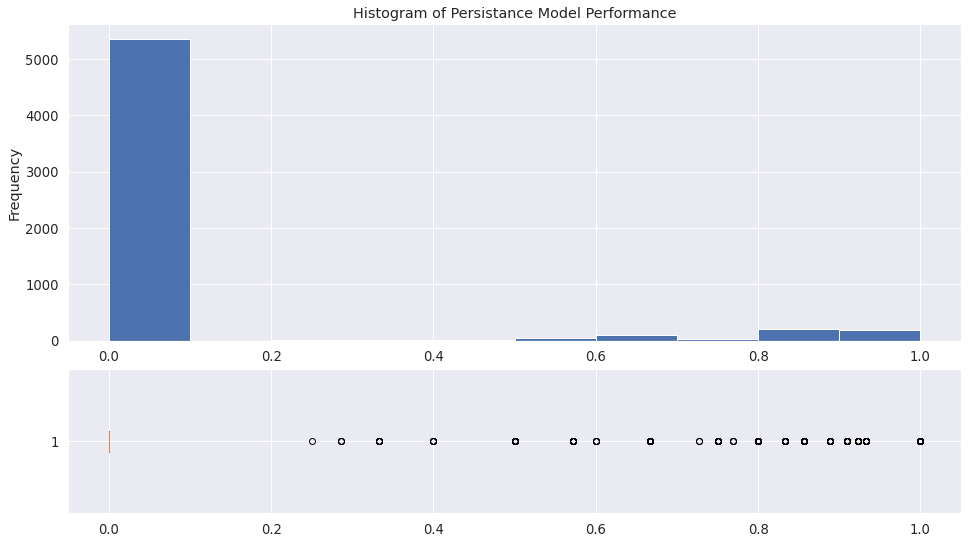

In [7]:
# create pivoted data
results = df.pivot(columns="customer_id")['predictions'].apply(model)
plt.subplot(3, 1, (1, 2))
results.plot(kind="hist", figsize=(16, 9), title="Histogram of Persistance Model Performance")
plt.subplot(3, 1, 3)
plt.boxplot(results, vert=False)
plt.show()

Our persistance model does a terrible job with a majority of the f1 scores returned being below .1, meaning there is some serious error in the predictions, and just using the previous month's value won't work.

### ML Classification Algorithms

In [8]:
# Create dictionary of baseline classifiers
clfs = {
    "Logistic Regression": LogisticRegression(fit_intercept=False, solver="liblinear", random_state=1234124, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=1234124),
    "Random Forest": RandomForestClassifier(criterion="entropy", n_jobs=-1, random_state=1234124),
    "RF AdaBoost": AdaBoostClassifier(random_state=1234124),
    "RF Bagging": BaggingClassifier(n_jobs=-1, random_state=1234124),
    "RF GradientBoost": GradientBoostingClassifier(random_state=1234124),
    "RF XGBoost": XGBRFClassifier(n_jobs=-1, random_state=1234124),
}

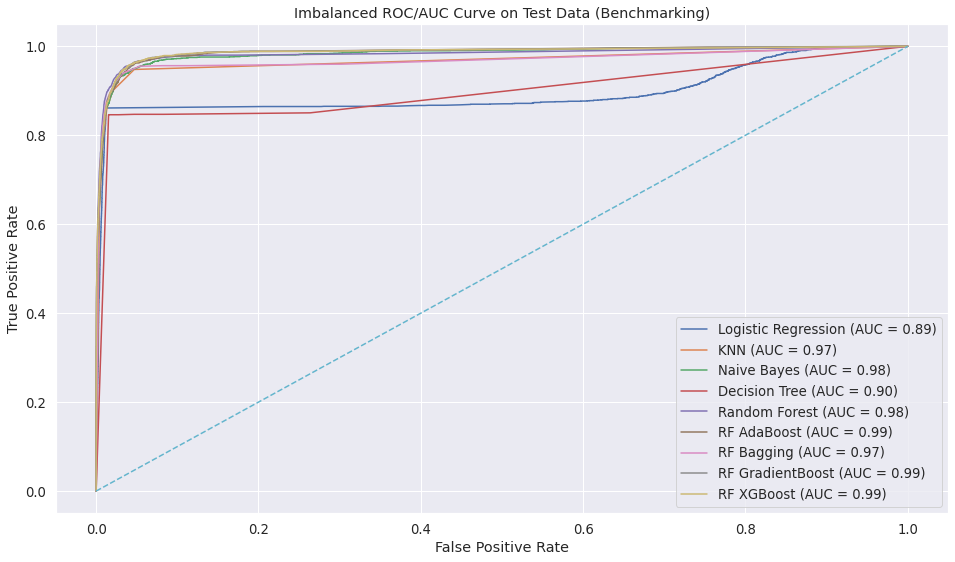

In [9]:
# train all models, get training f1 score plot roc_curve

fig, ax = plt.subplots(figsize=(16, 9))

tscv = TimeSeriesSplit()

results = []
for (model, clf) in clfs.items():
    # CV scoring of classifier
    cv_f1_scoring = []
    for train_index, test_index in tscv.split(X):
        X_train_f, X_test_f = X.iloc[train_index], X.iloc[test_index]
        y_train_f, y_test_f = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train_f, y_train_f)
        preds = clf.predict(X_test_f)
        cv_f1_scoring.append(metrics.f1_score(y_test_f, preds))
        
    cv_f1_score = np.array(cv_f1_scoring).mean()
    # train classifier
    clf.fit(X_train, y_train) # we'll use the last trained classifier
    # make testing predictions
    test_pred = clf.predict(X_test)
    # f1 score on test data
    test_f1 = f1_score(y_test, test_pred)
    #plot roc/auc
    plot_roc_curve(clf, X_test, y_test, name=model, ax=ax)
    #append f1 results
    results.append([model, cv_f1_score, test_f1])

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title("Imbalanced ROC/AUC Curve on Test Data (Benchmarking)")
plt.show()

In [10]:
# dataframe of cv and test f1 scores, sorted by best test f1 score
scores = pd.DataFrame(results, columns=["classifier", "cv_f1", "test_f1"])
scores.sort_values("test_f1", ascending=False)

,classifier,cv_f1,test_f1
4,Random Forest,0.812773,0.860195
6,RF Bagging,0.800045,0.845482
8,RF XGBoost,0.828603,0.838829
5,RF AdaBoost,0.829618,0.838354
0,Logistic Regression,0.825998,0.837477
2,Naive Bayes,0.828174,0.837284
7,RF GradientBoost,0.829216,0.837284
1,KNN,0.806837,0.831312
3,Decision Tree,0.733179,0.810063


Looking at the ROC curves, its quite amazing to see that Decision Tree based classifiers do extremely well and are able to separate the data extremely well. Looking at the CV and test f1 scores for our data, the top 2 in terms of test f1 scores, are Decision Tree and Random Forest. There does appear to be some low bias, moderate variance with these two as the cv scores are 10 points below the testing f1 scores. We'll choose to move forward with the Random forest classifier, as it has the second highest test f1 score, while maintaining a CV score above .8.

## Random Forest

In [11]:
# train and predict a random forest model
rf = RandomForestClassifier(random_state=12312424, n_jobs=-1)
rf.fit(X_train, y_train)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

In [12]:
# output scores
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.999799,0.983393,0.999046,0.991528
Testing,0.842753,0.875473,0.982946,0.858802


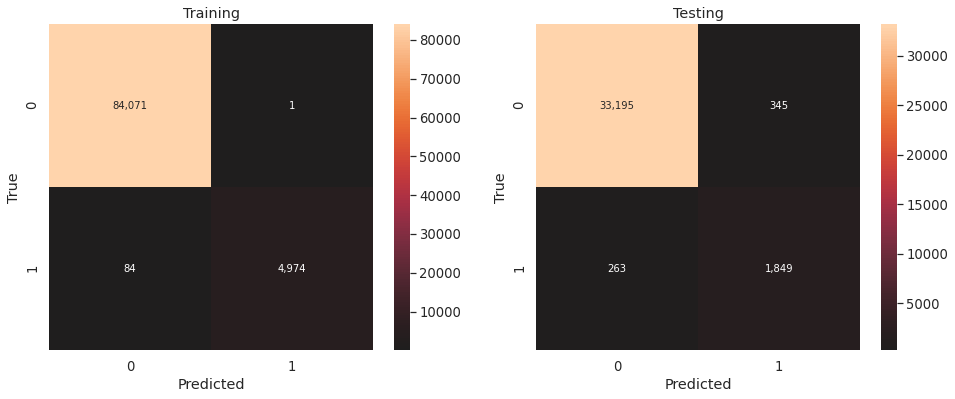

In [13]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

Goal here is to reduce false negatives, our goal is to market to get our recall score up since that indicates how well we can predict true positives.

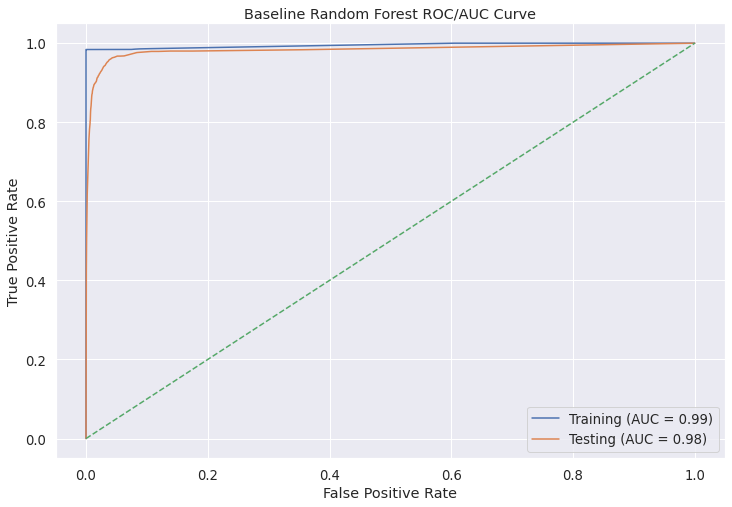

In [14]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(rf, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(rf, X_test, y_test, name="Testing", ax=ax)
line = np.linspace(0, 1)

plt.plot(line, line, "--")

plt.title("Baseline Random Forest ROC/AUC Curve")
plt.show()

### Tuning

Next up is tuning, we'll be looking to increase our performance by optimizing our recall score. We'll use a randomized grid search to sample a set of the possible parameters we could use. This will allow us to quickly ascertain the possible gains we can get by changing our parameters.

In [15]:
# create param grid, and random grid search
param_grid = {
    "n_estimators": np.arange(100, 350),
    "max_depth": np.arange(1, 10),
    "min_samples_leaf": stats.uniform(),
    "max_features": stats.uniform(),
    
}
rs = RandomizedSearchCV(
    RandomForestClassifier(criterion="gini", random_state=12312424, n_jobs=-1),
    param_grid,
    n_iter=25,
    scoring="recall",
    n_jobs=-1,
    random_state=123124323
)
rs.fit(X_train, y_train)
print(rs.best_params_)

{'max_depth': 6, 'max_features': 0.6132933194863682, 'min_samples_leaf': 0.022640328934705356, 'n_estimators': 232}


In [16]:
# predictions and scoring
train_pred = rs.predict(X_train)
test_pred = rs.predict(X_test)

a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.881695,0.810399,0.983070,0.844545
Testing,0.817161,0.861269,0.980366,0.838635


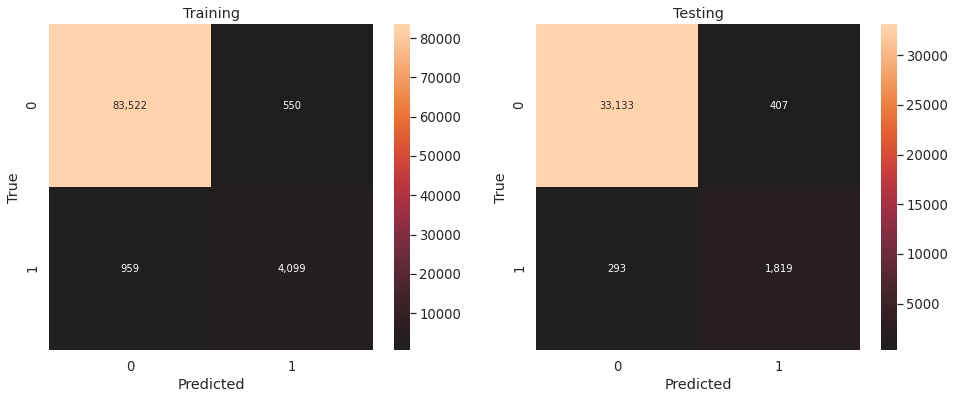

In [17]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

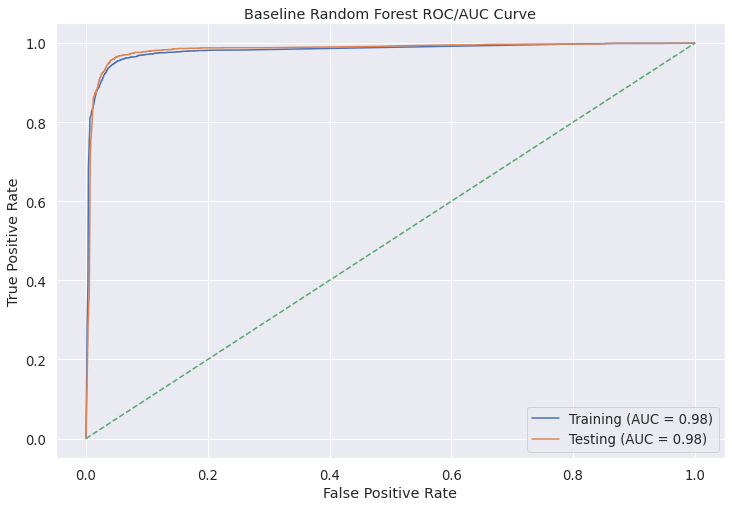

In [18]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(rs, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(rs, X_test, y_test, name="Testing", ax=ax)
line = np.linspace(0, 1)

plt.plot(line, line, "--")

plt.title("Baseline Random Forest ROC/AUC Curve")
plt.show()

We're actually underperforming with these randomly generated models, and our baseline seems to do better for the most part. We'll see the results on our holdout dataset.

## Holdout data

In [19]:
# train and predict a random forest model
rf = RandomForestClassifier(random_state=12312424, n_jobs=-1)
rf.fit(X_train, y_train)

holdX = holdout.dropna().drop(columns=['y', 'customer_id'])
holdy = holdout.dropna()['y']

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

holdout_pred = rf.predict(holdX)

In [20]:
# output scores
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
c = praf1(holdy, holdout_pred, "Holdout")
pd.concat([a, b, c])

,precision,recall,accuracy,f1
Training,0.999799,0.983393,0.999046,0.991528
Testing,0.842753,0.875473,0.982946,0.858802
Holdout,0.861371,0.808086,0.977752,0.833878


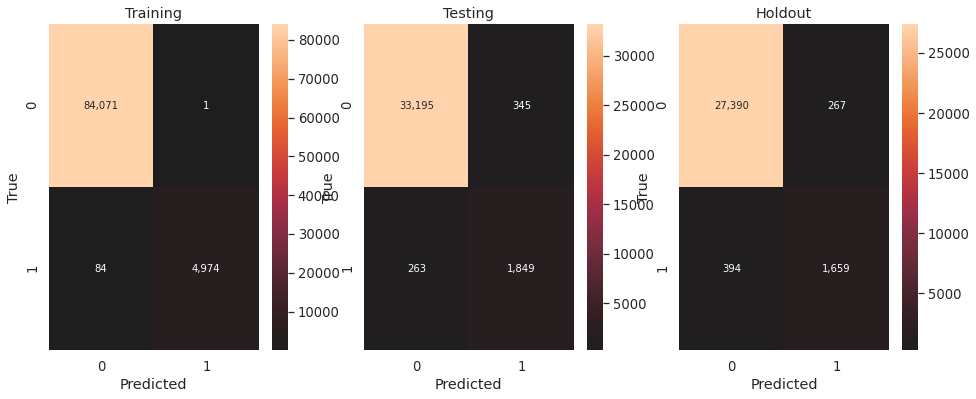

In [21]:
# output confusion matrix
confmat([y_train, y_test, holdy], [train_pred, test_pred, holdout_pred], ["Training", "Testing", "Holdout"])

Goal here is to reduce false negatives, our goal is to market to get our recall score up since that indicates how well we can predict true positives.

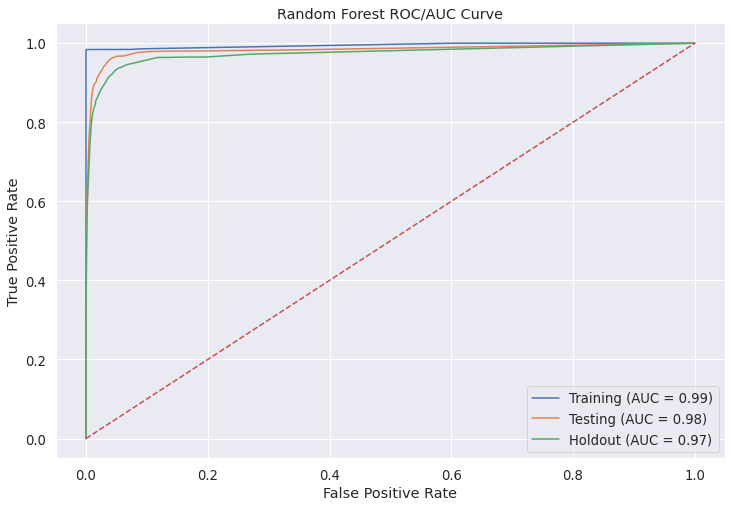

In [22]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(rf, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(rf, X_test, y_test, name="Testing", ax=ax)
plot_roc_curve(rf, holdX, holdy, name="Holdout", ax=ax)
line = np.linspace(0, 1)

plt.plot(line, line, "--")

plt.title("Random Forest ROC/AUC Curve")
plt.show()

We can see that our separability is already really good with this model during training and testing.